# Assignment 1

## Assumption
1. Polytope is non-degenerate.
2. Polytope is bounded
3. Rak of A is n

Implement the simplex algorithm to maximize the objective function, You need to implement the method discussed in class.

Input: CSV file with m+2 rows and n+1 column.
             The first row excluding the last element is the initial feasible point z of length n
             The second row excluding the last element is the cost vector c of length n
             The last column excluding the top two elements is the constraint vector b of length m
             Rows third to m+2 and column one to n is the matrix A of size m*n

Output: You need to print the sequence of vertices visited and the value of the objective function at that vertex

## Used Functions


## imports
**Details of Libraries:**
   - **`numpy`** - Importing for the numerical computations, like matrix operations & vector manipulations.
   - **`matplotlib.pyplot`**: Importing for the creation of plots that helps in visualizing results.
   - **`scipy.linalg.null_space`**: Importing for the computing of null space of an matrix, useful in the linear programming & feasibility checks.
   - **`seaborn`**: The visualization library built on top of `matplotlib`, will be used here for enhancing aesthetic quality of the plots.
   - **`csv`**: For reading & writing CSV files containing input data.

In [16]:
# importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space
from scipy.optimize import linprog
import seaborn as sns
import csv

## read_csv
This `read_csv` function will read i/p CSV file & extracts required components for simplex algorithm. It will open file & convert data from that file into structured NumPy arrays-  first row going for parsing as initial feasible solution, second row as cost vector, &  an last column of remaining rows as right-hand side vector. Preceding columns from those rows form constraint matrix. This function makes sure that data is correctly structured & also ready for  the use in solving linear programming problem and also streamlining input process & minimizing manual errors.


In [17]:
def read_csv(filename):
    # to read CSV file (input) and extract init_feasible_sol, cost_vec, A, and rhs_vec matrix
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        data = list(reader)

    # Extracting the initial feasible solution from 1st row
    init_feasible_sol = np.array([float(x) for x in data[0][:-1]])

    # Extracting the cost vector from the second row
    cost_vec = np.array([float(x) for x in data[1][:-1]])

    # Extracti gthe right-hand side (RHS) vector from  remaining rows
    rhs_vec = np.array([float(row[-1]) for row in data[2:]])

    # Extracting constraints matrix
    A = np.array([[float(x) for x in row[:-1]] for row in data[2:]])

    return A, init_feasible_sol, rhs_vec, cost_vec

## Reading & Visualizing Input Data

This code is reading CSV input file using `read_csv` function for extrating necessary components for simplex algorithm, such as constraint matrix \the \), initial feasible solution, cost vectors, & right-hand side vector. It will print the matrices to console for verification. Additionally, the heatmap of constraint matrix \the \) is plotted using `seaborn` library for visualzing represent structure of constraints. This will helps us in understanding relationships between variables & constraints in linear programming problem.


Constraint Matrix (A):
 [[ 0.  1.]
 [ 1.  0.]
 [-1. -1.]]

Initial Feasible Solution (init_feasible_sol): [0. 0.]

Cost Vector (cost_vec): [5. 2.]

Right-Hand Side Vector (rhs_vec): [1. 1. 1.]


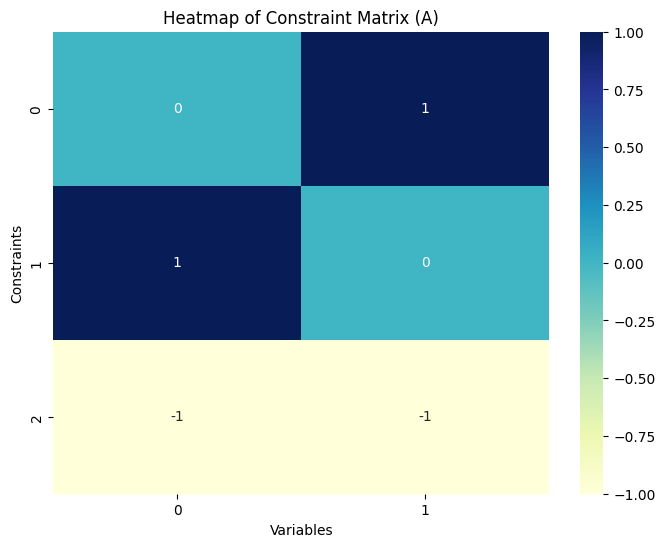

In [18]:
# to read the CSV file (input)
A, init_feasible_sol, rhs_vec, cost_vec = read_csv('testcase_1.csv')

# Printing the matrices
print("Constraint Matrix (A):\n", A)
print("\nInitial Feasible Solution (init_feasible_sol):", init_feasible_sol)
print("\nCost Vector (cost_vec):", cost_vec)
print("\nRight-Hand Side Vector (rhs_vec):", rhs_vec)

# Ploting heatmap of constraint matrix A
plt.figure(figsize=(8, 6))
sns.heatmap(A, annot=True, cmap="YlGnBu", cbar=True)
plt.title('Heatmap of Constraint Matrix (A)')
plt.xlabel('Variables')
plt.ylabel('Constraints')
plt.show()

##  Identifying Tight Rows in Constraint Matrix

`find_tight_rows` function identifies which constraints in matrix \( A \) are tight for given initial feasible solution. It perform this by computing the diff between result of dot product of \( A \) & initial solution, & right-hand side vector \( b \). If an absolute difference is smaller than the specified tolerance (\( \epsilon \)), then that row is considered tight. Function then separates matrix \( A \) into 2  part-: `tight_rows`, which will be containing rows where constraints are tight, & `untight_rows`, which contains rows where constraints are not tight. This distinction is vey important to determinine which constraints are active in that feasible region of solution.


In [19]:
# determining tight rows from constraint matrix
def find_tight_rows(A, init_feasible_sol, rhs_vec, epsilon=1e-8):

    # Checking if the diff is less than a small epsilon to identify tight rows
    tight_mask = np.abs(np.dot(A, init_feasible_sol) - rhs_vec) < epsilon

    # Selecting the rows where the constraint is tight
    tight_rows = A[tight_mask]

    # Selecting the rows where the constraint are not tight
    untight_rows = A[~tight_mask]

    return tight_mask, tight_rows, untight_rows

## Identifying Tight & Untight Constraints for Initial Feasible Solution
This code calls `find_tight_rows` function for determining  which constraints are tight for that given initial feasible solution. Function returns the mask which is indicating tightness of each constraint, as well as specific rows in constraint matrix \( A \) that are tight (`tight_rows`) & those that are not found tight (`untight_rows`). This separation is important for the understanding of which constraints actively define feasible region of current solution in our simplex algorithm.


In [20]:
# Find tight rows for initial feasible solution
mask, tight_rows, untight_rows = find_tight_rows(A, init_feasible_sol, rhs_vec)

##  feasible_to_vertex
`feasible_to_vertex` function is designed for converting initial feasible solution into vertex of feasible region for linear programming problem. It will starts by calculating the cost at initial solution & then identifies tight constraints using our `find_tight_rows` function. If there are no tight constraints are present or rank of tight constraints is less than number of variables, function will determine direction for moving in solution space. This direction is derived either from null space of tight constraints or from the chosen randomly if no tight constraints exist. Function then will calculate step size (alpha usesd below) for moving in that direction which will be ensuring updated solution remains feasible. Process then repeats iteratively, updating solution & tracking visited vertices, until vertex is found or all the constraints are satisfied. This function is very crucial for generating feasible solutions that will guide simplex algorithm towards optimal solution.


In [21]:
def feasible_to_vertex(A, rhs_vec, init_feasible_sol, cost_vec, n):
    # to convert initial_feasible_point into a vertex.

    vertices = []
    costs = []
    iteration = 0
    costs.append(np.dot(cost_vec, init_feasible_sol))
    vertices.append(init_feasible_sol)

    mask, tight_rows, untight_rows = find_tight_rows(A, init_feasible_sol, rhs_vec)

    while len(tight_rows) == 0 or np.linalg.matrix_rank(tight_rows) < n:
        print(f"Iteration {iteration}: Current Cost = {costs[-1]}, Current Vertex = {init_feasible_sol}")

        if len(tight_rows) != 0:
            direction = null_space(tight_rows)[:, 0]  # Direction from null space
        else:
            direction = np.random.rand(untight_rows.shape[-1])  # Random direction

        # initialize an empty arrya for alpha values
        alphas = []

        # iterating through the rhs_vec and untight_rows
        for b_i, a_i in zip(rhs_vec[~mask], untight_rows):
            # Compute the denominator, the dot product of a_i and the direction
            denominator = np.dot(a_i, direction)

            # Checking is  denominator is +ve i.e valid direction
            if denominator > 0:
                # calculateing the numerator the difference between b_i and the dot product of a_i with init_feasible_sol
                numerator = b_i - np.dot(a_i, init_feasible_sol)

                # Compute the alpha value as the ratio of numerator to denominator
                alpha = numerator / denominator

                # Appending the alpha value in th list alpha
                alphas.append(alpha)

        # Finding the minimum value of alphas
        alpha = min(alphas)
        # Updateing the initial feasible solution by moving in the direction specified by direction and step size will determined by alpha
        init_feasible_sol = init_feasible_sol + alpha * direction

        # Appending the updated feasible solution
        vertices.append(init_feasible_sol)

        #cost is computed as the dot product of the cost vector and the updated solution
        costs.append(np.dot(cost_vec, init_feasible_sol))

        mask, tight_rows, untight_rows = find_tight_rows(A, init_feasible_sol, rhs_vec)

        # incrementing the iteration
        iteration += 1

    return init_feasible_sol, costs, vertices

## Converting Initial Feasible Solution to a Vertex and Tracking Costs
This code is defining no. of variables \( n \) based on number of columns in that constraint matrix \( A \). It calls `feasible_to_vertex` function to convet initial feasible solution into the vertex of feasible region. function returns updated solution (`init_feasible_sol`), sequence of costs at each vertex (`costs`), and list of vertices visited during process (`vertices`). This step is essential for moving from an initial feasible solution to an optimal vertex while tracking objective function values throughout iterations.


In [22]:
# Defining number of variables
n = A.shape[1]

# Convert feasible point to a vertex
init_feasible_sol, costs, vertices = feasible_to_vertex(A, rhs_vec, init_feasible_sol, cost_vec, n)

Iteration 0: Current Cost = 0.0, Current Vertex = [0. 0.]
Iteration 1: Current Cost = 5.814649671421449, Current Vertex = [1.         0.40732484]


## Plotting Cost Changes During Conversion to the Vertex

This code is plotting changes in objective function value over the iterations as initial feasible solution is converted into the vertex. The `costs` list, which is containsing objective values at each vertex visited, is used for creating line plot with iteration numbers on x axis & corresponding objective values on y axis. The plots plotted by this will help in visualizing how objective function evolves as algorithm progresses toward finding an optimal vertex in the feasible region. Grid & markers on plots are enhancing readability and also providing the clear view of changes at each of the step.


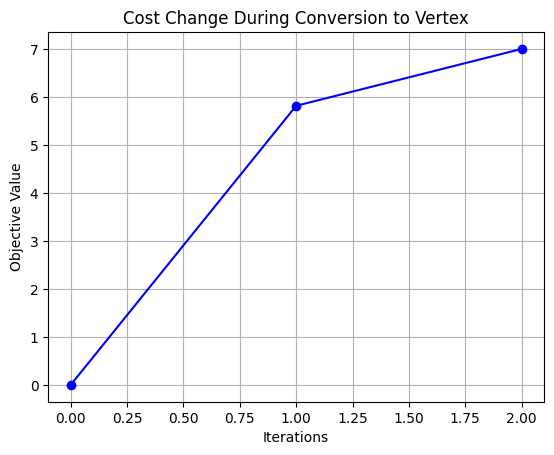

In [23]:
# Plot cost changes during the conversion process
plt.plot(range(len(costs)), costs, marker='o', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.title('Cost Change During Conversion to Vertex')
plt.grid(True)
plt.show()

## Computing Directions Using Tight Constraints

 Based on the tight constraints of the current solution, `compute_directions` function is computing direction vectors. It takes matrix of tight constraints as input, where each row represents the constraint that is active for the given solution. The function is attempting for calculation of the inverse of the tight rows matrix & returning its negative value. For determining the direction of movement within the feasible region, this inverse matrix is used. An exception is raised if the matrix is singular (that is non invertible), & function will  prints an error message, returning `None` to indicate that the direction could not be computed for that case. This function is very crucial for the simplex algorithm, as it helping to identify the direction in which that solution can move for improving that objective function.


In [24]:
# This fuction is for computing vectors using the tight rows.
def compute_directions(tight_rows):
    #  It is taking matrix of tight constraints as input.
    # Each row is representing the constraints that are currently active for given solution

    try:
        return -np.linalg.inv(tight_rows) # This is computing & returning - ve inverse of tight rows matrix.
    except np.linalg.LinAlgError:
        # If an tight_rows matrix is singular (i.e. non invertible) then the exception is raised.
        print("It is Singular Matrix, So cannot compute directions.")   # Handling non invertible matrix
        return None # Returning None for indicating that the directions could not be computed

## Vertex Optimization Using Simplex Method
 The `vertex_optimization` function implements core of Simplex method for optimizing solution iteratively by moving from one vertex to next. For storing visited vertices and corresponding objective function values, our function starts by initializing lists. It begins with given initial feasible solution & cost associated with it.

In each iteration, function -
1. Calls `find_tight_rows` function and identifies tight & untight constraints.
2. Computes the potential directions for movement purpose based on tight constraints using function `compute_directions`.
3. By checking which ones improve objective function , it Filters directions (positive dot product with cost vector).
4. If no improving direction is found then the algorithm terminates which is indicating optimal solution had reached.
5. If improving directions exist, then it is selecting first one & computes step sizes for untight constraints.
6. Smallest positive alpha is determining step size to move towards next vertex.
7. Solution is updated by moving along chosen direction & new vertex is added into the list of visited vertices.
8. The objective function value at new solution is computed & is stored.
 Loop continues till no improving direction is found which is indicating that optimal solution had reached.

Finally, function will returns optimal solution, sequence of costs, and the vertices visited during optimization process.

This function forms the heart of Simplex algorithm hence most important, iterating through feasible solutions and then improving objective function at each step until the optimal vertex is found.


In [25]:
# This function for optimizing an solution by moving iteratively to the next vertex from one vertex using Simplex Method.
def vertex_optimization(A, rhs_vec, init_feasible_sol, cost_vec):

    vertices = []   # This is  List for Storing the visited vertices
    costs = []      # This is List for storing objective function at each vertex
    iteration = 0

    # Appending initial feasible solution &  its cost to lists.
    vertices.append(init_feasible_sol)
    costs.append(np.dot(cost_vec, init_feasible_sol))

    while True:
        # Current iteration details printing
        print(f"Iteration {iteration}: Current Cost = {costs[-1]}, Current Vertex = {init_feasible_sol}")

        # For current solution, identifing tight & untight constraints
        mask, tight_rows, untight_rows = find_tight_rows(A, init_feasible_sol, rhs_vec)

        # Computign the potential directions for the movement based on tight constraints
        directions = compute_directions(tight_rows).T

        # Checking dot product with cost vector & Filtering directions
        positive_directions = []
        for d in directions:
            if np.dot(d, cost_vec) > 0:
                positive_directions.append(d)

        if not positive_directions:
            break

        # Choosing first improving direction
        direction = positive_directions[0]

        # Computeing step sizes - alphas, for untight constraints
        dot_products = [np.dot(a_i, direction) for a_i in untight_rows]

        # Filtering valid dot products & computing alphas
        valid_alphas = []
        for b_i, a_i, dot_product in zip(rhs_vec[~mask], untight_rows, dot_products):
            if dot_product > 0:
                alpha = (b_i - np.dot(a_i, init_feasible_sol)) / dot_product
                valid_alphas.append(alpha)

        # After that, valid_alphas will be containing computed alphas

        # Updating  solution for next vertex along direction which is chosen
        init_feasible_sol = init_feasible_sol + min(valid_alphas) * direction

        # Recording new solution & its objective function value of that solution
        costs.append(np.dot(cost_vec, init_feasible_sol))
        vertices.append(init_feasible_sol)

        # Incramenting counter of iterator
        iteration += 1
    # Returning here optimal solution, sequence of costs & visited vertices
    return init_feasible_sol, costs, vertices


## Optimizing Solution Using Simplex Method

This code calls `vertex_optimization` function for performinig optimization process using Simplex method. This function takes constraint matrix \( A \), the right hand side vector \( rhs\_vec \), the initial feasible solution `init_feasible_sol` also cost vector `cost_vec` as i/p. It will returns the optimal vertex (`optimal_vertex`), the sequence of costs at each visited vertex (`optimization_costs`), & also list of visited vertices (`optimization_vertices`). The optimization process iterates through feasible solutions, which improves the objective function at each step, until the optimal solution is found, which occurs at end.


In [26]:
# Optimizing the vertex using the Simplex method
optimal_vertex, optimization_costs, optimization_vertices = vertex_optimization(A, rhs_vec, init_feasible_sol, cost_vec)

Iteration 0: Current Cost = 7.0, Current Vertex = [1. 1.]


## Plotting Tight Constraints Over Iterations

A plot will be generated by this code for showing how the no. of tight constraints changes over the iterations of the Simplex algorithm. For each of teh visited vertex in the list `vertices`, the `find_tight_rows` function is used to determine how many tight constraints are active at that particular vertex. This count is finally plotted against the no. of iterations.

The plot helps  us to visualize how the set of active constraints evolves as progress of algorithm which provids insight into the changing feasible region and the constraints that govern solution at each step.


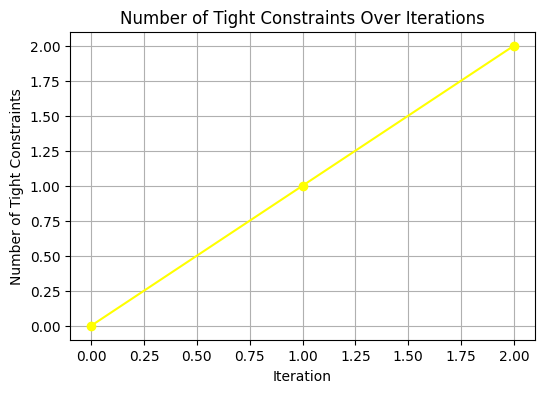

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(vertices)), [np.sum(find_tight_rows(A, v, rhs_vec)[0]) for v in vertices], marker='o', color='yellow')
plt.xlabel('Iteration')
plt.ylabel('Number of Tight Constraints')
plt.title('Number of Tight Constraints Over Iterations')
plt.grid(True)
plt.show()

In [28]:
# Optimizing the vertex using the Simplex method
print("\nSequence of visited Vertices are as follows:")
optimal_vertex, optimization_costs, optimization_vertices = vertex_optimization(A, rhs_vec, init_feasible_sol, cost_vec)

print("\nOptimal vertex is as follows:")
print(f"Point: {optimization_vertices[-1]}")
print(f"Value of objective function: {optimization_costs[0-1]}")



Sequence of visited Vertices are as follows:
Iteration 0: Current Cost = 7.0, Current Vertex = [1. 1.]

Optimal vertex is as follows:
Point: [1. 1.]
Value of objective function: 7.0
